<a href="https://colab.research.google.com/github/morebeautifulthandoriangray/Perceptron/blob/main/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Linear algebra and mathematical operations
import numpy as np 
#importing and loading data
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder

Далее мы будем использовать Pandas для загрузки и перемешивания набора данных. Такое случайное перемешивание помогает сделать данные более однородными и является хорошей практикой для предотвращения переобучения в будущем.

In [6]:
iris_df = pd.read_csv("sample_data/iris.csv")
iris_df = iris_df.sample(frac=1).reset_index(drop=True) # перемешиваем

Посмотрим наши данные:

In [ ]:
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,6.7,3.1,4.7,1.5,Versicolor
1,6.0,2.2,5.0,1.5,Virginica
2,7.6,3.0,6.6,2.1,Virginica
3,7.7,3.0,6.1,2.3,Virginica
4,6.6,2.9,4.6,1.3,Versicolor


Затем мы переключаемся с pandas DataFrame на массив numpy, чтобы данные можно было легко передать в нашу пользовательскую нейронную сеть.

In [7]:
X = iris_df[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']]
X = np.array(X)
X[:5]
X[0]

array([4.8, 3.4, 1.9, 0.2])

Поскольку столбец «Variety» является категориальным, мы должны изменить его на однократное кодирование. Поскольку мы все еще находимся на этапе предварительной обработки данных, проще использовать «OneHotEncoder» из библиотеки sklearn.preprocessing.

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
Y = iris_df.variety
Y = one_hot_encoder.fit_transform(np.array(Y).reshape(-1, 1))
Y[:]
# Y[0]

Пришло время разделить тест/обучение/проверку. Мы снова будем использовать sklearn для этого.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)

X_train, Y_train: The train set


X_val, Y_val: Validation set (optional)

epochs: Number of cycles (default = 10)

nodes: An integer list of number of nodes in every layer

lr: learning rate α (default = 0.15).

In [10]:
def NeuralNetwork(X_train, Y_train, X_val=None, Y_val=None, epochs=10, nodes=[], lr=0.15):
    hidden_layers = len(nodes) - 1
    weights = InitializeWeight(nodes)

    for epoch in range(1, epochs+1):
        weights = Train(X_train, Y_train, lr, weights)

        if(epoch % 20 == 0):
            print("Epoch {}".format(epoch))
            print("Training Accuracy:{}".format(Accuracy(X_train, Y_train, weights)))
            if X_val.any():
                print("Validation Accuracy:{}".format(Accuracy(X_val, Y_val, weights)))
            
    return weights

Функция InitializeWeight используется для случайной инициализации весов узлов в диапазоне от -1 до 1 включительно. Для реализации мы используем numpy для генерации случайных значений:

In [11]:
def InitializeWeight(nodes):
    layers, weights = len(nodes), []
    
    for i in range(1, layers):
        w = [[np.random.uniform(-1, 1) for j in range(nodes[i-1] + 1)]
              for k in range(nodes[i])]
        weights.append(np.matrix(w))
    
    return weights

Эти веса будут позже обновлены с использованием известного алгоритма обратного распространения ошибки. Чтобы это работало, нам нужно прямое распространение, при котором все входные данные умножаются и добавляются с соответствующими весами и смещениями.

Каждый слой получает входные данные от своего предыдущего слоя, кроме первого слоя нейронной сети.

Затем входные значения умножаются на соответствующие им веса. Смещение добавляется и передается через функцию активации.

Процесс повторяется на всех слоях. Результатом последнего слоя является предсказание нашей нейронной сети.

In [12]:
def ForwardPropagation(x, weights, layers):
    activations, layer_input = [x], x
    for j in range(layers):
        activation = Sigmoid(np.dot(layer_input, weights[j].T))
        activations.append(activation)
        layer_input = np.append(1, activation)
    
    return activations

Поскольку мы случайным образом инициализируем веса в начале процесса обучения, вывод после первого запуска может отличаться от фактического ответа. Алгоритм обратного распространения используется для борьбы с этим, вычисляя ошибку из последнего слоя и соответствующим образом обновляя веса в нейронной сети.



In [13]:
def BackPropagation(y, activations, weights, layers, lr):
    outputFinal = activations[-1]
    error = np.matrix(y - outputFinal) # Error after 1 cycle
    
    for j in range(layers, 0, -1):
        currActivation = activations[j]
        
        if(j > 1):
            # Append previous
            prevActivation = np.append(1, activations[j-1])
        else:
            # First hidden layer
            prevActivation = activations[0]
        
        delta = np.multiply(error, SigmoidDerivative(currActivation))
        weights[j-1] += lr * np.multiply(delta.T, prevActivation)

        wc = np.delete(weights[j-1], [0], axis=1)
        error = np.dot(delta, wc) #current layer error
    
    return weights

Все различные разделы нашей нейронной сети теперь построены. Демонстрационные данные сначала отправляются по сети путем переадресации. В конце слоя ошибки вычисляются и распространяются обратно для соответствующего обновления весов слоев.

In [14]:
def Train(X, Y, lr, weights):
    layers = len(weights)
    for i in range(len(X)):
        x, y = X[i], Y[i]
        x = np.matrix(np.append(1, x))
        
        activations = ForwardPropagation(x, weights, layers)
        weights = BackPropagation(y, activations, weights, layers, lr)

    return weights

Для нашей сети мы будем использовать сигмовидную функцию активации. Скалярный продукт каждого слоя проходит через функцию активации, которая определяет конечный результат этого слоя. Сигмоид имеет диапазон (0,1). Он в основном используется в моделях, где требуется прогноз вероятности (следовательно, диапазон от 0 до 1). Поскольку наша модель должна «угадывать» вид цветка, лучше всего подходит сигмоидальная функция.

In [15]:
def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def SigmoidDerivative(x):
    return np.multiply(x, 1-x)

Окончательный вывод нашей сети будет иметь вид [i, j, k], соответствующий трем классам, где i, j, k — действительные числа в диапазоне [0,1]. Чем выше значение, тем выше шансы, что это правильный класс. Наша задача — установить максимальное значение равным 1, а остальные — равным 0, где 1 обозначает прогнозируемый класс.

In [16]:
def Predict(item, weights):
    layers = len(weights)
    item = np.append(1, item)
    
    # Forward prop.
    activations = ForwardPropagation(item, weights, layers)
    
    Foutput = activations[-1].A1
    index = FindMaxActivation(Foutput)

    y = [0 for j in range(len(Foutput))]
    y[index] = 1 

    return y 


def FindMaxActivation(output):
    m, index = output[0], 0
    for i in range(1, len(output)):
        if(output[i] > m):
            m, index = output[i], i
    
    return index

Наконец, мы оцениваем предсказания нашей нейронной сети, беря предсказанный класс и сравнивая его с фактическим классом, чтобы получить точность в процентах.

Доступны многие типы метрик оценки, но в рамках этой статьи мы будем использовать простую процентную меру.

In [17]:
def Accuracy(X, Y, weights):
    correct = 0

    for i in range(len(X)):
        x, y = X[i], list(Y[i])
        guess = Predict(x, weights)

        if(y == guess):
            # Right prediction
            correct += 1

    return correct / len(X)

Наша нейронная сеть готова! Давайте запустим его и проверим результаты.



In [18]:
f = len(X[0]) # no. of features
o = len(Y[0]) # no. of classes

layers = [f, 5, 10, o] # no. of nodes 
L, E = 0.15, 100

weights = NeuralNetwork(X_train, Y_train, X_val, Y_val, epochs=E, nodes=layers, lr=L);


Epoch 20
Training Accuracy:0.6403508771929824
Validation Accuracy:0.5384615384615384
Epoch 40
Training Accuracy:0.8245614035087719
Validation Accuracy:0.8461538461538461
Epoch 60
Training Accuracy:0.7982456140350878
Validation Accuracy:0.7692307692307693
Epoch 80
Training Accuracy:0.8157894736842105
Validation Accuracy:0.8461538461538461
Epoch 100
Training Accuracy:0.8771929824561403
Validation Accuracy:0.9230769230769231


In [19]:
print("Testing Accuracy: {}".format(Accuracy(X_train, Y_train, weights)))

Testing Accuracy: 0.8771929824561403


In [20]:
print("Testing Accuracy: {}".format(Accuracy(X_val, Y_val, weights)))

Testing Accuracy: 0.9230769230769231


In [21]:
print("Testing Accuracy: {}".format(Accuracy(X_test, Y_test, weights)))

Testing Accuracy: 0.9130434782608695


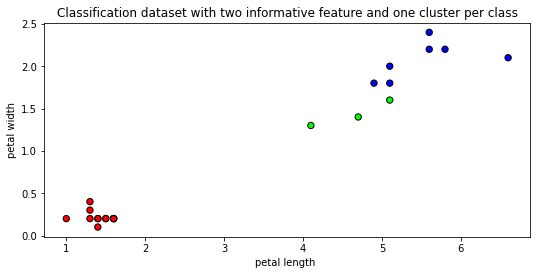

In [29]:
# Importing libraries
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Plotting the dataset
plt.figure(figsize=(7.50, 3.50))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)
plt.subplot(111)
plt.title("Classification dataset with two informative feature and one cluster per class", fontsize="12")
plt.scatter(X_test[:, 2], X_test[:, 3], marker="o", c=Y_test, s=40, edgecolor="k")
plt.xlabel("petal length ")
plt.ylabel("petal width")
plt.show()

# X_test[:, 2] petal length like x
# X_test[:, 3] petal width like y